# Importing necessary libraries 

In [174]:
pip install psycopg2-binary

In [187]:
 if get_ipython().__class__.__module__ == "google.colab._shell":
  !pip -q install --no-cache-dir --upgrade git+https://3dbbf9c3bc8ca549a0bf05ac163ebbf18dedaff5@github.com/nlabmsc/nlabproxypostgres.git
  import nlabproxypostgres
  import psycopg2
  psycopg2.connect = nlabproxypostgres.proxy_psycopg2_connect
else:
   import psycopg2 
import psycopg2
from getpass import getpass
import pandas as pd

In [188]:
user = 'lixsr43'
db_ip = '10.158.72.122'
pw = getpass('Enter the database password for {}: '.format(user))

Enter the database password for lixsr43: ··········


In [0]:
import numpy as np
import pandas as pd

# Making Temporal Features

In [0]:
def get_dataset( reference_day = '2019-10-23', tumbling_window_size = 7, output_window_size = 27, num_periods = 10, window_agg_fun = 'SUM',window_agg_fun2='SUM', window_agg_fun3='COUNT', output_fun='CASE WHEN SUM'):
    
    sql_top = """
    SELECT customer_id,
    %(ref_date)s::DATE AS ref_day,
    {0}(DISTINCT CASE WHEN purchased_at::DATE > %(ref_date)s::DATE AND purchased_at::DATE <= %(ref_date)s::DATE + %(ows)s::INT THEN ABS(receipt_id) ELSE 0 END) <> 0 THEN 1 ELSE 0 END as output_feature,
    """.format(output_fun)

    sql = sql_top

    for i in range(0,num_periods):
           sql += "{2}(CASE WHEN purchased_at::DATE > %(ref_date)s::DATE -%(ws)s::INT*({0}+1) AND purchased_at::DATE <= %(ref_date)s::DATE-%(ws)s::INT*({0}) THEN {3} ELSE 0 END) as vf{1},\n".format(i, i+1, window_agg_fun, "value")  
    
    for i in range(0,num_periods):
      sql += "{2} (DISTINCT CASE WHEN purchased_at::DATE > %(ref_date)s::DATE -%(ws)s::INT*({0}+1) AND purchased_at::DATE <= %(ref_date)s::DATE-%(ws)s::INT*({0}) THEN qty ELSE 0 END) as qf{1},\n".format(i, i+1, window_agg_fun2)

    for i in range(0,num_periods):
      sql += "{2} (Distinct CASE WHEN purchased_at::DATE > %(ref_date)s::DATE -%(ws)s::INT*({0}+1) AND purchased_at::DATE <= %(ref_date)s::DATE-%(ws)s::INT*({0}) THEN ABS(receipt_id) END) as freq_f{1},\n".format(i, i+1, window_agg_fun3)  
      
    sql_bottom = """   
    FROM ml16.receipts join ml16.receipt_lines using(receipt_id)
    where purchased_at > ('2018-06-13 00:00:00')
    GROUP BY customer_id
    having count(purchased_at) > 1 
    """
    sql = sql[:-2] + sql_bottom
    
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
        df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})
        df.set_index('customer_id')
        input_feature = df.drop(columns = ['ref_day','output_feature'], inplace = False)
    
    return input_feature, df.output_feature

In [0]:
X,y=get_dataset( reference_day = '2019-10-23', tumbling_window_size = 7, output_window_size = 27)

In [104]:
X.head(10)

,customer_id,vf1,vf2,vf3,vf4,vf5,vf6,vf7,vf8,vf9,vf10,qf1,qf2,qf3,qf4,qf5,qf6,qf7,qf8,qf9,qf10,freq_f1,freq_f2,freq_f3,freq_f4,freq_f5,freq_f6,freq_f7,freq_f8,freq_f9,freq_f10
0,8,0.00,21.61,24.23,0.00,18.12,0.00,21.61,0.00,26.15,22.83,0,1,3,0,1,0,1,0,3,1,0,1,1,0,1,0,1,0,1,1
1,25,0.00,0.00,0.00,0.00,9.66,0.00,0.00,0.00,0.00,0.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,47,7.31,0.00,0.00,0.00,0.00,3.84,0.00,13.34,12.00,12.65,3,0,0,0,0,1,0,3,5,3,1,0,0,0,0,1,0,2,1,1
3,56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.34,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,69,0.00,0.00,6.75,0.00,0.00,0.00,5.24,8.25,0.00,8.12,0,0,1,0,0,0,3,3,0,3,0,0,1,0,0,0,1,1,0,1
8,85,20.63,4.95,24.23,12.96,67.36,31.00,9.44,19.07,18.52,7.34,3,1,3,3,6,3,3,7,1,3,3,2,4,1,4,3,2,2,3,3
9,89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Model Evaluation 

Random forest:

In [190]:
from sklearn import metrics
from datetime import date, timedelta
import datetime
from sklearn.ensemble import RandomForestClassifier
tumbling_window_size = 7
output_window_size = 27
total_holdout = 8
now= '2019-10-23'
now_day= datetime.datetime.strptime(now, '%Y-%m-%d').date()
model = RandomForestClassifier(n_estimators = 120)
accuracy =[]
precision =[]
recall=[]
for i in range(total_holdout):
    test_x, test_y = get_dataset(str(now_day - timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    test_x= test_x.loc[test_x['freq_f1'] > 0]
    ind = list(test_x.index.values) 
    test_y = test_y.loc[test_y.index.isin(ind)]
    train_x, train_y = get_dataset(str(now_day - 2*timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    train_x= train_x.loc[train_x['freq_f1'] > 0]
    ind = list(train_x.index.values)
    train_y=train_y.loc[train_y.index.isin(ind)]
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
    accuracy1= metrics.accuracy_score(test_y, preds)
    precision1 = metrics.precision_score(test_y, preds, pos_label=1)
    recall1 = metrics.recall_score(test_y, preds, pos_label=1)
    accuracy.append(accuracy1)
    precision.append(precision1)
    recall.append(recall1)
    now_day = now_day - timedelta(days=output_window_size)
print('accuracy_RF: ',np.mean(accuracy) )
print('Precision_RF: ',np.mean(precision) )
print('Recall_RF: ',np.mean(recall))

2020-06-08 13:51:52,050| ERROR   | Could not establish connection from ('127.0.0.1', 35122) to remote side of the tunnel


OperationalError: ignored

Support Vector Classifier:

In [0]:
from datetime import date, timedelta
import datetime
from sklearn.svm import SVC
clf = SVC(kernel='rbf', gamma=1, random_state=42)
tumbling_window_size = 7
output_window_size = 27
total_holdout = 8
now= '2019-10-23'
now_day= datetime.datetime.strptime(now, '%Y-%m-%d').date()
accuracy =[]
precision =[]
recall=[]
for i in range(total_holdout):
    test_x, test_y = get_dataset(str(now_day - timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    test_x= test_x.loc[test_x['freq_f1'] > 0]
    ind = list(test_x.index.values) 
    test_y = test_y.loc[test_y.index.isin(ind)]
    train_x, train_y = get_dataset(str(now_day - 2*timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    train_x= train_x.loc[train_x['freq_f1'] > 0]
    ind = list(train_x.index.values)
    train_y=train_y.loc[train_y.index.isin(ind)]
    clf.fit(train_x, train_y)
    preds = clf.predict(test_x)
    accuracy1= metrics.accuracy_score(test_y, preds)
    precision1 = metrics.precision_score(test_y, preds, pos_label=1)
    recall1 = metrics.recall_score(test_y, preds, pos_label=1)
    accuracy.append(accuracy1)
    precision.append(precision1)
    recall.append(recall1)
    now_day = now_day - timedelta(days=output_window_size)
print('accuracy_svc: ',np.mean(accuracy) )
print('Precision_svc: ',np.mean(precision) )
print('Recall_svc: ',np.mean(recall))

working
working
working
working
accuracy_svc:  0.7621885296603204
Precision_svc:  0.7621885296603204
Recall_svc:  1.0


Decision Tree classifier:

In [142]:
from datetime import date, timedelta
import datetime
from sklearn import tree
tree_clf = tree.DecisionTreeClassifier(random_state=42, max_depth=20)
tumbling_window_size = 27
output_window_size = 7
total_holdout = 8
now= '2019-10-23'
now_day= datetime.datetime.strptime(now, '%Y-%m-%d').date()
accuracy =[]
precision =[]
recall=[]
for i in range(total_holdout):
    test_x, test_y = get_dataset(str(now_day - timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    test_x= test_x.loc[test_x['freq_f1'] > 0]
    ind = list(test_x.index.values) 
    test_y = test_y.loc[test_y.index.isin(ind)]
    train_x, train_y = get_dataset(str(now_day - 2*timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    train_x= train_x.loc[train_x['freq_f1'] > 0]
    ind = list(train_x.index.values)
    train_y=train_y.loc[train_y.index.isin(ind)]
    tree_clf.fit(train_x, train_y)
    preds = tree_clf.predict(test_x)
    accuracy1= metrics.accuracy_score(test_y, preds)
    precision1 = metrics.precision_score(test_y, preds, pos_label=1)
    recall1 = metrics.recall_score(test_y, preds, pos_label=1)
    accuracy.append(accuracy1)
    precision.append(precision1)
    recall.append(recall1)
    now_day = now_day - timedelta(days=output_window_size)
print('accuracy_DT: ',np.mean(accuracy) )
print('Precision_DT: ',np.mean(precision) )
print('Recall_DT: ',np.mean(recall))

working


2020-06-08 13:10:58,887| ERROR   | Problem setting SSH Forwarder up: Couldn't open tunnel 0.0.0.0:7122 <> 10.158.72.122:5432 might be in use or destination not reachable


HandlerSSHTunnelForwarderError: ignored

# Final Prediction

In [122]:
from sklearn import metrics
from datetime import date, timedelta
import datetime
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
tumbling_window_size = 7
output_window_size = 27
total_holdout = 8
now= '2019-11-19'
now_day= datetime.datetime.strptime(now, '%Y-%m-%d').date()
model = RandomForestClassifier(n_estimators = 100)
for i in range(total_holdout):
    test_x, test_y = get_dataset(str(now_day - timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    test_x= test_x.loc[test_x['freq_f1'] > 0]
    ind = list(test_x.index.values) 
    test_y = test_y.loc[test_y.index.isin(ind)]
    train_x, train_y = get_dataset(str(now_day - 2*timedelta(days=output_window_size)), tumbling_window_size, output_window_size)
    train_x= train_x.loc[train_x['freq_f1'] > 0]
    ind = list(train_x.index.values)
    train_y=train_y.loc[train_y.index.isin(ind)]
    model.fit(train_x, train_y)
    preds = model.predict(test_x)
print(model.predict(test_x))

working
working
working
working
[1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0
 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1
 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1
 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0
 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1

In [123]:
df_pred = pd.DataFrame(preds, index=test_x.index, columns=['preds'])
df_pred

,preds
2,1
7,1
8,1
10,0
11,0
...,...
1613,0
1616,0
1618,0
1621,0


# Pen Portraits

In [126]:
ind_churn_pred=list(df_pred[df_pred['preds']==0].index.values)
test_x[test_x.index.isin(ind_churn_pred)].describe()

,customer_id,vf1,vf2,vf3,vf4,vf5,vf6,vf7,vf8,vf9,vf10,qf1,qf2,qf3,qf4,qf5,qf6,qf7,qf8,qf9,qf10,freq_f1,freq_f2,freq_f3,freq_f4,freq_f5,freq_f6,freq_f7,freq_f8,freq_f9,freq_f10
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,8484.405970,25.911224,17.007940,15.372597,16.151373,14.090657,14.047463,15.678597,14.493910,13.097731,16.317582,3.280597,1.955224,1.901493,1.710448,1.671642,1.773134,1.859701,1.797015,1.376119,1.564179,1.597015,1.014925,0.964179,0.961194,0.880597,0.907463,0.928358,0.946269,0.823881,1.002985
std,4807.424746,30.486034,32.291535,30.858958,34.088273,33.618495,29.557853,30.687796,31.394095,29.227306,40.237963,2.409825,3.172830,2.799567,2.736378,3.030721,2.972306,3.156784,3.321224,2.307634,3.272261,1.067479,1.408832,1.420098,1.565435,1.365994,1.366988,1.439686,1.501529,1.550168,2.107157
min,104.000000,0.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4403.500000,9.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8766.000000,16.660000,0.920000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12607.000000,31.875000,22.260000,20.385000,20.565000,16.955000,20.015000,20.660000,18.780000,14.080000,16.105000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
max,16301.000000,306.970000,309.560000,387.710000,370.960000,334.650000,358.550000,249.750000,367.480000,206.560000,369.890000,17.000000,25.000000,16.000000,18.000000,34.000000,25.000000,19.000000,25.000000,18.000000,36.000000,9.000000,8.000000,9.000000,13.000000,9.000000,8.000000,8.000000,10.000000,13.000000,19.000000


In [127]:
ind_churn_pred=list(df_pred[df_pred['preds']==1].index.values)
test_x[test_x.index.isin(ind_churn_pred)].describe()

,customer_id,vf1,vf2,vf3,vf4,vf5,vf6,vf7,vf8,vf9,vf10,qf1,qf2,qf3,qf4,qf5,qf6,qf7,qf8,qf9,qf10,freq_f1,freq_f2,freq_f3,freq_f4,freq_f5,freq_f6,freq_f7,freq_f8,freq_f9,freq_f10
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.00000,154.000000,154.000000
mean,7822.584416,110.633831,92.437662,104.658052,89.021948,95.610649,87.646234,83.290649,85.426234,81.932792,76.847013,5.584416,4.941558,5.318182,5.162338,5.253247,4.889610,4.357143,5.084416,4.896104,4.025974,6.896104,5.935065,6.538961,6.103896,6.194805,5.506494,5.610390,5.61039,5.519481,5.272727
std,4516.978649,129.734299,112.710142,125.172940,128.357933,126.706737,121.196259,126.127382,121.829311,118.293774,121.343799,3.815519,4.122689,3.881756,3.879679,3.770476,3.974694,4.085169,4.544553,4.322262,3.422242,5.469068,5.099885,5.159081,5.794034,6.108045,5.768119,6.057795,5.69636,5.873638,6.074992
min,47.000000,1.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,4264.500000,40.225000,29.240000,31.467500,24.305000,28.785000,21.582500,15.917500,19.945000,19.362500,17.382500,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,2.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.00000,2.000000,1.000000
50%,7671.000000,73.745000,63.555000,70.930000,48.380000,61.285000,52.685000,47.735000,50.620000,52.155000,43.215000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,5.000000,5.000000,5.000000,4.500000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000
75%,11596.250000,137.530000,113.880000,126.927500,103.495000,120.370000,98.950000,103.395000,113.902500,98.857500,87.152500,7.000000,6.000000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,6.750000,6.000000,9.000000,8.000000,9.000000,7.000000,8.000000,7.000000,7.000000,8.00000,7.000000,6.000000
max,16070.000000,941.320000,779.690000,972.030000,946.160000,1106.390000,909.100000,1154.510000,957.520000,875.970000,1023.640000,21.000000,21.000000,28.000000,22.000000,16.000000,16.000000,22.000000,29.000000,21.000000,16.000000,33.000000,28.000000,26.000000,32.000000,40.000000,32.000000,34.000000,33.00000,29.000000,34.000000


In [0]:
churners=df_pred[df_pred.preds==0]
non_churners=df_pred[df_pred.preds==1]

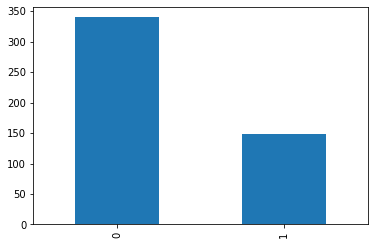

In [63]:
import numpy as np    
import matplotlib.pyplot as plt
df_pred['preds'].value_counts().plot(kind='bar');

In [0]:
list_of_churners=list(churners.index.values)
list_of_nonchurners=list(non_churners.index.values)

In [0]:
len(list_of_churners)

346

In [0]:
len(list_of_nonchurners)

143

In [0]:
sql = """
     select customer_id, sum(value) as total_val, count(distinct receipt_id) as freq
	from ml16.receipts
        join ml16.receipt_lines 
        using (receipt_id)
        group by customer_id
      """
with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
    df1 = pd.read_sql(sql, conn)

In [0]:
total_df=pd.concat([df1, df_pred], axis=1)

In [168]:
churners = total_df[total_df['preds']> 0]
non_churners = total_df[total_df['preds']< 1]

count_row1 = churners.shape[0] 
print('Churners',count_row1)

count_row2 = non_churners.shape[0] 
print('Non Churners',count_row2)

Churners 154
Non Churners 335


In [172]:
avg_value_churners = churners['total_val'].mean()
print('Average amount spent by churners till date=',avg_value_churners) 

avg_value_non_churners = non_churners['total_val'].mean()
print('Avgerage amount spent by non churners till date=',avg_value_non_churners) 

avg_freq_churners = churners['freq'].mean()
print('Avgerage number of visits by churners till date=',avg_freq_churners)

avg_freq_non_churners = non_churners['freq'].mean()
print('Avgerage number of visits by non churners till date=',avg_freq_non_churners) 

Average amount spent by churners till date= 234.1074025974027
Avgerage amount spent by non churners till date= 254.07635820895504
Avgerage number of visits by churners till date= 16.396103896103895
Avgerage number of visits by non churners till date= 15.605970149253732


# Feature Inportance

In [0]:
def print_variable_importances( feature_names, dict_in, show_top = 10 ):
 
  if show_top is None:
    show_top = len(feature_names)
  
  to_print_titles = []
  to_print_scores = []
  
  for k, v in dict_in.items():

    feature_names_plus_scores = sorted( zip(v, feature_names) )
    feature_names_plus_scores.reverse()
    to_print_titles.append(k)
    to_print_scores.append(feature_names_plus_scores)
    
  line_parts = []
  for j in range(len(to_print_titles)):
    line_parts.append('{:<38}'.format(to_print_titles[j]))
  
 
  print('Rank | ' + ' | '.join( ['{:<38}'.format(x) for x in to_print_titles] ) )
  

  print('---- + ' + ' + '.join( [ '-'*38 ]*len(to_print_titles) ) )
  
  for i in range(show_top):

    line_parts = []
    for j in range(len(to_print_titles)):
      line_parts.append(  '{:<30}: {:.4f}'.format(to_print_scores[j][i][1], to_print_scores[j][i][0]) )
  
    print( '{:<4} | '.format(str(i)) + ' | '.join(line_parts) )

In [0]:
X,y = get_dataset( reference_day = '2019-10-23', tumbling_window_size = 7, output_window_size = 27)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold = 0.0)
vt.fit(X_train)

X_train.columns[np.invert(vt.get_support())]

Index([], dtype='object')

In [0]:
!pip install -q eli5
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

# TASK 1
feature_importance_scores = {}
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

rf_perm = RandomForestClassifier()

rf_perm.fit(X_train_sub, y_train_sub)

perm = PermutationImportance(rf_perm, cv='prefit')

perm.fit(X_test_sub, y_test_sub)

y_pred = rf_perm.predict(X_test)
scores = accuracy_score(y_test, y_pred)

method_name = 'Perm non-cv RF ({:.2f})'.format(scores*100)

feature_importance_scores[method_name] = perm.feature_importances_

print_variable_importances( X_train.columns, feature_importance_scores )

Rank | Perm non-cv RF (76.39)                
---- + --------------------------------------
0    | freq_f5                       : 0.0056
1    | vf4                           : 0.0022
2    | freq_f9                       : 0.0022
3    | vf10                          : 0.0017
4    | vf1                           : 0.0017
5    | qf4                           : 0.0017
6    | qf2                           : 0.0017
7    | freq_f2                       : 0.0017
8    | vf2                           : 0.0006
9    | qf5                           : 0.0000


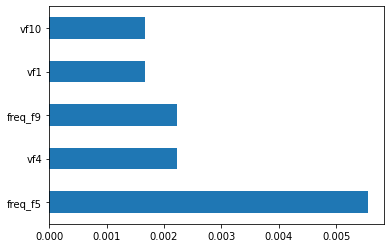

In [0]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(perm.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()